In [16]:
import cv2
from matplotlib import  pyplot as plt
import numpy as np

(512, 512)


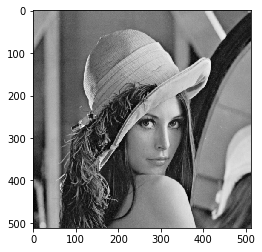

In [17]:
img = cv2.imread('./gray.jpg',cv2.IMREAD_UNCHANGED)
plt.imshow(img,cmap="gray")

print(img.shape)

In [18]:
Octive = int(np.log2(np.minimum(img.shape[0],img.shape[1])) - 3)

S = 6

In [19]:
sigma0 = 1.6
sigman = 0.5

In [20]:
sigma_list = np.zeros([Octive, S])

In [21]:
window_size = int(6 * sigman + 1)
if window_size%2 == 0:
    window_size = window_size + 1
img_initial = cv2.GaussianBlur(img,(window_size,window_size),sigman)

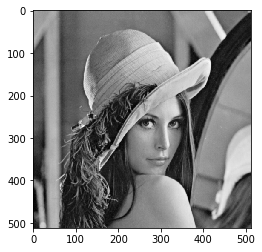

In [22]:
plt.imshow(img_initial,cmap = 'gray')


In [23]:
Gaussian_Pyramid = []

k = np.power(2, 1/(S - 3))

for octive in range(Octive):
    octive_cur = []

    if octive == 0:
        img_last = cv2.pyrUp(img_initial, dstsize = (img_initial.shape[0] * 2, img_initial.shape[1] * 2))
        sigma_0 = np.sqrt(sigma0**2 - (2 * sigman)**2)
    else:
        img_last = cv2.pyrDown(Gaussian_Pyramid[-1][-3], dstsize=(int(img_last.shape[0]/2), int(img_last.shape[1]/2)))
        sigma_0 = 2 * sigma_0
    sigma_last = sigma_0

    for s in range(S):
        sigma_cur = np.power(k, s)*sigma_0

        sigma_delta = np.sqrt(sigma_cur**2 - sigma_last**2)
        print(sigma_cur,sigma_last,sigma_delta)
        sigma_last = sigma_cur

        window_size = int(6 * sigma_delta)
        if(window_size%2 ==0):
            window_size = window_size + 1

        img_cur = cv2.GaussianBlur(img_last,(window_size,window_size),sigma_delta)
        octive_cur.append(img_cur)
        img_last = img_cur

    Gaussian_Pyramid.append(octive_cur)
    print("")

1.2489995996796799 1.2489995996796799 0.0
1.5736408869466987 1.2489995996796799 0.9572594429256847
1.982663278439384 1.5736408869466987 1.2060713223527098
2.4979991993593598 1.982663278439384 1.5195546467067236
3.1472817738933974 2.4979991993593598 1.9145188858513693
3.965326556878768 3.1472817738933974 2.4121426447054195

2.4979991993593598 2.4979991993593598 0.0
3.1472817738933974 2.4979991993593598 1.9145188858513693
3.965326556878768 3.1472817738933974 2.4121426447054195
4.9959983987187195 3.965326556878768 3.039109293413447
6.294563547786795 4.9959983987187195 3.8290377717027386
7.930653113757536 6.294563547786795 4.824285289410839

4.9959983987187195 4.9959983987187195 0.0
6.294563547786795 4.9959983987187195 3.8290377717027386
7.930653113757536 6.294563547786795 4.824285289410839
9.991996797437439 7.930653113757536 6.078218586826894
12.58912709557359 9.991996797437439 7.658075543405477
15.861306227515072 12.58912709557359 9.648570578821678

9.991996797437439 9.991996797437439 0.

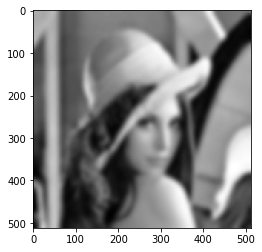

In [24]:
plt.imshow(Gaussian_Pyramid[1][4],'gray')

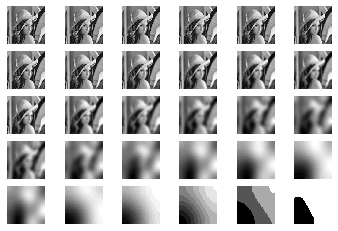

In [25]:
plt.figure()
for oct in range(octive):
    for idx in range(S):
        plt.subplot(octive, S, oct * S + idx + 1)
        plt.axis('off')
        plt.imshow(Gaussian_Pyramid[oct][idx],'gray')
plt.show()

In [26]:
DoG = []

for oct in range(octive):
    DoG_octive = []
    for idx in range(S-1):
        gaussian_img1 = np.asarray(Gaussian_Pyramid[oct][idx],dtype='int16')
        gaussian_img2 = np.asarray(Gaussian_Pyramid[oct][idx + 1],dtype='int16')
        DoG_octive.append(gaussian_img2 - gaussian_img1)

    DoG.append(DoG_octive)

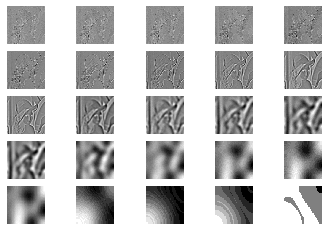

In [27]:
plt.figure()
for oct in range(octive):
    for idx in range(S - 1):
        plt.subplot(octive, S - 1, oct * (S - 1) + idx + 1)
        plt.axis('off')
        plt.imshow(DoG[oct][idx],'gray')
plt.show()

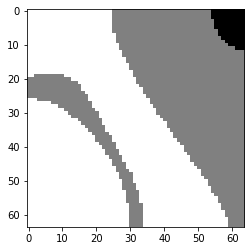

In [28]:
plt.imshow(DoG[4][4],'gray')

In [67]:
def campareSquare(pixel, square, camp = 0):
    if camp == 0:
        return (pixel >= square[0][0] and pixel >= square[0][1] and pixel >= square[0][2] and
                pixel >= square[1][0] and pixel >= square[1][1] and pixel >= square[1][2] and
                pixel >= square[2][0] and pixel >= square[2][1] and pixel >= square[2][2])
    else:
        return (pixel <= square[0][0] and pixel <= square[0][1] and pixel <= square[0][2] and
                pixel <= square[1][0] and pixel <= square[1][1] and pixel <= square[1][2] and
                pixel <= square[2][0] and pixel <= square[2][1] and pixel <= square[2][2])


def assertExtremum(cube, threshold):
    center_pixel = cube[1,1,1]

    if np.abs(center_pixel) > threshold:
        return (campareSquare(center_pixel, cube[0], 0) and
                campareSquare(center_pixel, cube[1], 0) and
                campareSquare(center_pixel, cube[2], 0)) or\
               (campareSquare(center_pixel, cube[0], 1) and
                campareSquare(center_pixel, cube[1], 1) and
                campareSquare(center_pixel, cube[2], 1))
    else:
        return False

In [34]:
def getGradient(cube):
    dx = 0.5 * (cube[1,1,2] - cube[1,1,0])
    dy = 0.5 * (cube[1,2,1] - cube[1,0,1])
    ds = 0.5 * (cube[2,1,1] - cube[0,1,1])
    return np.array([dx, dy, ds])

In [52]:
def getHessian(cube):
    center_pixel = cube[1][1][1]
    dxx = cube[1,1,2] - 2 * center_pixel + cube[1,1,0]
    dyy = cube[1,2,1] - 2 * center_pixel + cube[1,0,1]
    dss = cube[2,1,1] - 2 * center_pixel + cube[0,1,1]
    dxy = 0.25 * (cube[1,2,2] - cube[1,2,0] - cube[1,0,2] + cube[1,0,0])
    dxs = 0.25 * (cube[2,1,2] - cube[2,1,0] - cube[0,1,2] + cube[0,1,0])
    dys = 0.25 * (cube[2,2,1] - cube[2,0,1] - cube[0,2,1] + cube[0,0,1])
    return np.array([[dxx, dxy, dxs],
                     [dxy, dyy, dys],
                     [dxs, dys, dss]])

In [38]:
constant_threshold = 0.04
threshold = np.floor(constant_threshold / S * 0.5 * 255)
keypoints = []
img_border_width = 5
num_iterate_max = 5


for oct in range(Octive):
    for interval in range(S - 2):
        img_first = np.asarray(DoG[0][0])
        img_second = np.asarray(DoG[0][1])
        img_third = np.asarray(DoG[0][2])
        height, width = img_first.shape
        for i in range(img_border_width,height - img_border_width):
            for j in range(img_border_width, width - img_border_width):
                 cube = np.stack([img_first[i-1:i+2,j-1:j+2],
                                img_second[i-1:i+2,j-1:j+2],
                                img_third[i-1:i+2,j-1:j+2]]).astype('float32')

                 if assertExtremum(cube, threshold) :
                    extremum_outside_image = False
                    iterate_idx_last = 0
                    for iterate_idx in range(num_iterate_max):
                        iterate_idx_last = iterate_idx
                        cube = cube / 255
                        gradient = getGradient(cube)
                        hessian = getHessian(cube)
                        extremum_update = np.linalg.lstsq(hessian, gradient, rcond=None)[0]
                        if all(abs(extremum_update) < 0.5):
                            break
                        j += int(round(extremum_update[0]))
                        i += int(round(extremum_update[1]))
                        #TODO: interval
                        if i < img_border_width or i >= height or j < img_border_width or j >= width:
                            extremum_outside_image = True
                            break

                    if extremum_outside_image:
                        continue
                    if iterate_idx_last >= num_iterate_max -1:
                        continue

                    finalExtremum = cube[1][1][1] + 0.5 * gradient.dot(extremum_update)







ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [248]:
i=10
j=10

img_first = np.asarray(DoG[0][0])
img_second = np.asarray(DoG[0][1])
img_third = np.asarray(DoG[0][2])
cube = np.stack([img_first[i-1:i+2,j-1:j+2],
                img_second[i-1:i+2,j-1:j+2],
                img_third[i-1:i+2,j-1:j+2]]).astype('float32')

cube

array([[[-2., -1., -1.],
        [-1., -2., -1.],
        [-1., -2., -1.]],

       [[-1., -1., -1.],
        [-2., -1., -1.],
        [-2., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -2.]]], dtype=float32)

In [249]:
print(assertExtremum(cube,0.5))

False


In [24]:

keypoints

[[5, 846],
 [5, 847],
 [5, 848],
 [5, 849],
 [6, 847],
 [6, 848],
 [6, 849],
 [7, 846],
 [7, 847],
 [7, 848],
 [7, 849],
 [8, 846],
 [8, 847],
 [8, 848],
 [8, 849],
 [8, 1002],
 [9, 847],
 [9, 848],
 [9, 849],
 [9, 850],
 [9, 851],
 [10, 847],
 [10, 848],
 [10, 849],
 [10, 850],
 [10, 851],
 [10, 852],
 [11, 848],
 [11, 849],
 [11, 850],
 [11, 851],
 [11, 852],
 [11, 1018],
 [12, 849],
 [12, 850],
 [12, 1017],
 [12, 1018],
 [13, 641],
 [13, 850],
 [13, 853],
 [13, 854],
 [13, 1015],
 [13, 1016],
 [13, 1017],
 [13, 1018],
 [14, 851],
 [14, 852],
 [14, 853],
 [14, 854],
 [14, 855],
 [14, 1013],
 [14, 1014],
 [14, 1015],
 [14, 1016],
 [14, 1017],
 [14, 1018],
 [15, 130],
 [15, 851],
 [15, 852],
 [15, 853],
 [15, 854],
 [15, 855],
 [15, 1010],
 [15, 1011],
 [15, 1012],
 [15, 1013],
 [15, 1014],
 [15, 1015],
 [15, 1016],
 [15, 1017],
 [15, 1018],
 [16, 807],
 [16, 808],
 [16, 851],
 [16, 852],
 [16, 1010],
 [16, 1011],
 [16, 1012],
 [16, 1013],
 [16, 1014],
 [16, 1015],
 [16, 1016],
 [16, 1

In [25]:
len(keypoints)

2267640

In [77]:
extremum_update = np.array([1,-3,1])
if all(abs(extremum_update) < 2):
    print(1)
else:
    print(2)


2
